# Simulation test code

## Simple 2-node network model with Wilson-Cowan type dynamics 

#### Takuya Ito (taku.ito1@gmail.com)
#### 11/29/2018

In [1]:
import numpy as np
import BalloonWindkessel as bw
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import seaborn as sns
plt.style.use('ggplot')
sns.set_style('white')

# 1.0 Define functions

Let $x_1$ be an excitatory neuron. Let $x_2$ be an inhibitory neuron. Define $w_ij$ to be the weight from neuron $x_i$ to $x_j$.

To identify the rate of change for the firing rates for these neuronal populations, we have

$$\tau_1 \frac{dx_1}{dt} = -x_1 + f\Big( w_{11} x_1 + w_{21} x_2 + b_1 + s_1 \Big) \qquad \qquad (2)$$

$$\tau_2 \frac{dx_2}{dt} = -x_2 + f\Big( w_{12} x_1 + w_{22} x_2 + b_2 + s_2 \Big) \qquad \qquad (3)$$

Where $f(x)$ refers to the nonlinear function defined above, $\tau_i$ refers to the time constant of neuron $i$, and $s_i$ is the gain on neuron $i$.


In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-.5*x))

def runSim(w11,w12,w22,w21,d1,d2,b1,b2,s1,s2,t,xinit1,xinit2,tau1,tau2,dt=.1):
    I1 = np.zeros((t,))
    I2 = np.zeros((t,))
    # Set initial conditions
    I1[0] = xinit1
    I2[0] = xinit2
    
    for i in range(1,t):
        i1k1 = -I1[i-1] + sigmoid(w11*I1[i-1]+w21*I2[i-1]+b1+d1[i-1]+s1[i-1]) 
        i1k1 = i1k1/tau1
        i2k1 = -I2[i-1] + sigmoid(w22*I2[i-1]+w12*I1[i-1]+b2+d2[i-1]+s2[i-1]) 
        i2k1 = i2k1/tau2
        
        i1a = I1[i-1] + i1k1*dt
        i2a = I2[i-1] + i2k1*dt
        
        i1k2 = -i1a + sigmoid(w11*i1a+w21*i2a+b1+d1[i]+s1[i])
        i1k2 = i1k2/tau1
        i2k2 = -i2a + sigmoid(w22*i2a+w12*i1a+b2+d2[i]+s2[i]) 
        i2k2 = i2k2/tau2
        
        I1[i] = I1[i-1] + dt*((i1k1+i1k2)/2)
        I2[i] = I2[i-1] + dt*((i2k1+i2k2)/2)
        
    return I1[25:], I2[25:]

def findFP(w11,w12,w22,w21,b1,b2,s1,s2,t,xinit1,xinit2,tau1,tau2,dt=.1):
    """
    Finds the fixed point of the model for a particular parameter regime
    """
    I1 = np.zeros((t,))
    I2 = np.zeros((t,))
    # Set initial conditions
    I1[0] = xinit1
    I2[0] = xinit2
    
    for i in range(1,t):
        i1k1 = -I1[i-1] + sigmoid(w11*I1[i-1]+w21*I2[i-1]+b1+s1) 
        i1k1 = i1k1/tau1
        i2k1 = -I2[i-1] + sigmoid(w22*I2[i-1]+w12*I1[i-1]+b2+s2) 
        i2k1 = i2k1/tau2
        
        i1a = I1[i-1] + i1k1*dt
        i2a = I2[i-1] + i2k1*dt
        
        i1k2 = -i1a + sigmoid(w11*i1a+w21*i2a+b1+s1)
        i1k2 = i1k2/tau1
        i2k2 = -i2a + sigmoid(w22*i2a+w12*i1a+b2+s2) 
        i2k2 = i2k2/tau2
        
        I1[i] = I1[i-1] + dt*((i1k1+i1k2)/2)
        I2[i] = I2[i-1] + dt*((i2k1+i2k2)/2)
        
        if I1[i] == I1[i-1] and I2[i] == I2[i-1]: 
            I1fp = I1[i] 
            I2fp = I2[i]
            break        
        
    return I1fp, I2fp

## Parameters

In [73]:
# Set connectivity weights
w11 = 2
w22 = 2
w12 = 4
w21 = 4


# Set biases
b1 = -3
b2 = -3
# Set time constants
tau1 = 0.1
tau2 = 0.1

# 2.0 Run simulations

In [126]:
bw = reload(bw)

Range: 0.0014152264739778955


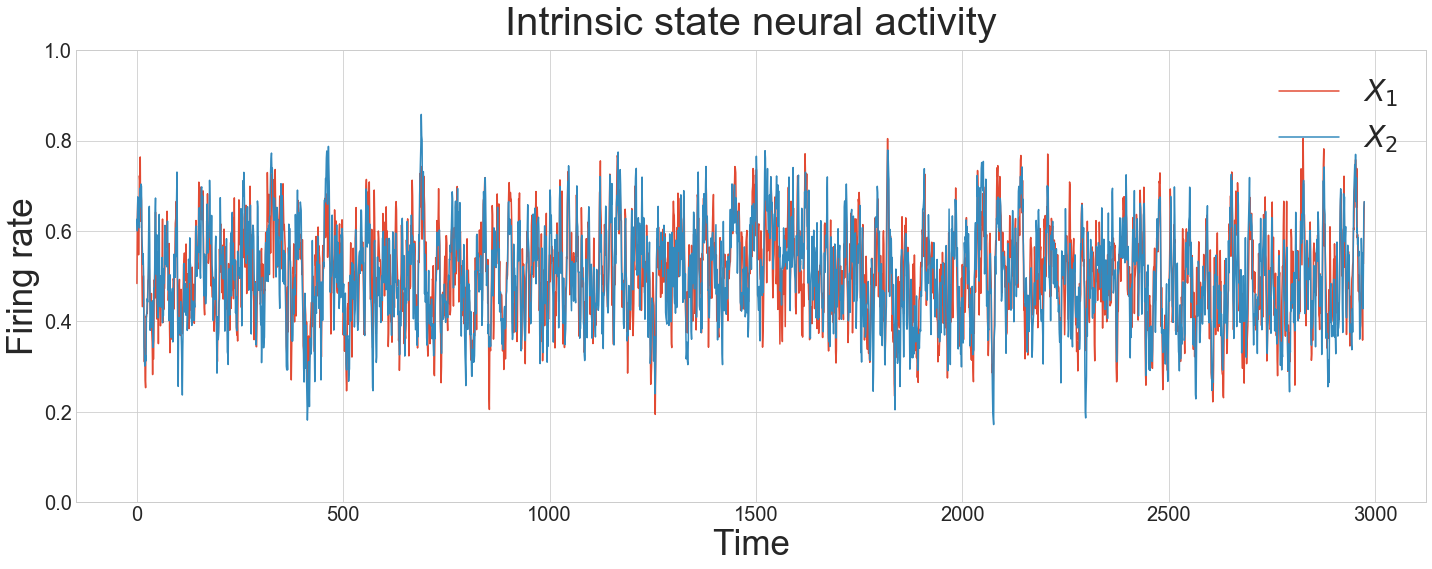

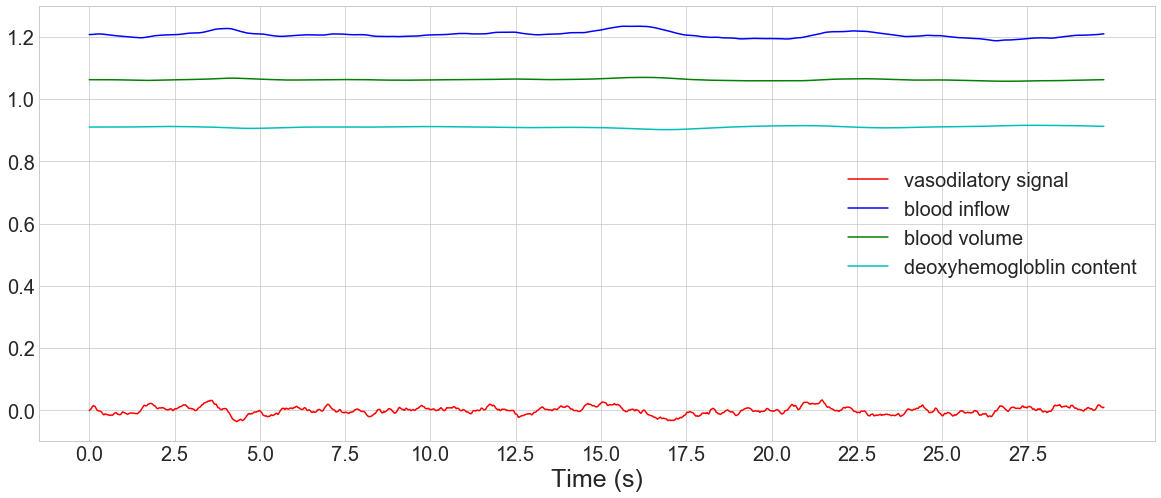

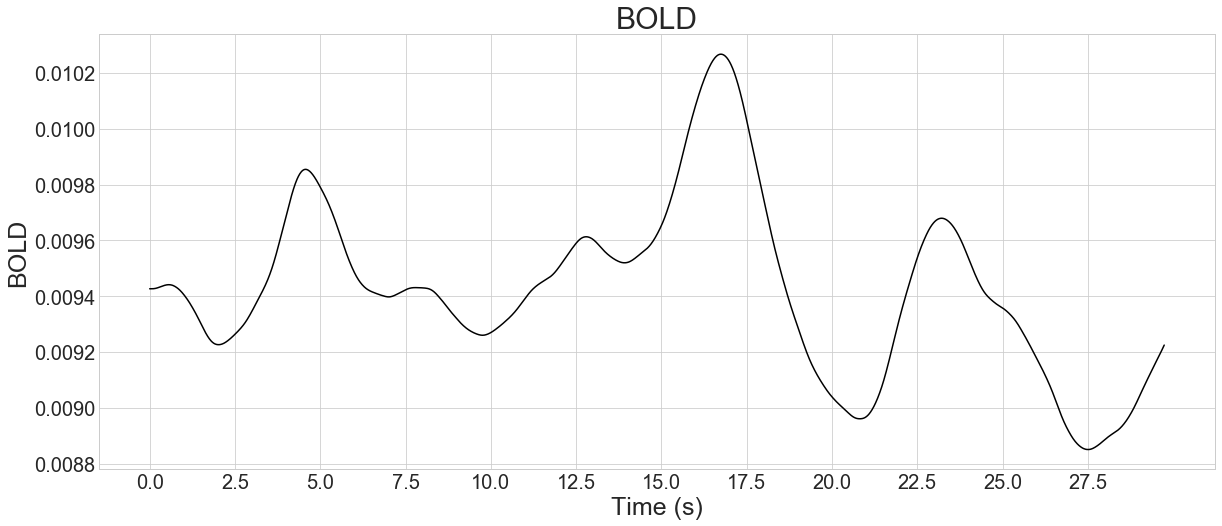

In [130]:
# Set n timepoints
t = 3000

# d1 = np.zeros((t,))
# d2 = np.zeros((t,))
d1 = np.random.normal(0,1.0,(t,))
d2 = np.random.normal(0,1.0,(t,))
s1 = 0
s2 = 0
s1vec = np.ones((t,))*s1
s2vec = np.ones((t,))*s2
# Set stimulation only to region 1
# s1[stimOnset:stimOffset] = 0

## Identify fixed point
xinit1 = 0
xinit2 = 0
I1fp, I2fp = findFP(w11,w12,w22,w21,b1,b2,s1,s2,10000,xinit1,xinit2,tau1,tau2,dt=.1)

# Set initial conditions
xinit1 = I1fp
xinit2 = I2fp

#####
## Run simulations
I1, I2 = runSim(w11,w12,w22,w21,d1,d2,b1,b2,s1vec,s2vec,t,xinit1,xinit2,tau1,tau2)


# Generate plots
plt.figure(figsize=(20,8))
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

# Plot
sns.set_style('whitegrid')
plt.plot(range(len(I1)),I1,label='$X_1$')
plt.plot(range(len(I2)),I2,label='$X_2$')
plt.xlabel('Time',fontsize=35)
plt.ylabel('Firing rate',fontsize=35)
plt.title('Intrinsic state neural activity', fontsize=40,y=1.02)
lgd = plt.legend(loc=1,prop={'size': 30})
plt.ylim([0,1.0])
plt.tight_layout()

# Transform BOLD activity
sampling_rate = 0.01 # in seconds
z = np.vstack((I1,I2))

BOLD, s, f, v, q = bw.balloonWindkessel(z, sampling_rate=sampling_rate) 

plt.figure(figsize=(20,8))
plt.plot(s[0,:],'r',label='vasodilatory signal')
plt.plot(f[0,:],'b',label='blood inflow')
plt.plot(v[0,:],'g',label='blood volume')
plt.plot(q[0,:],'c',label='deoxyhemogloblin content')
plt.xticks(np.arange(0,t,250),np.arange(0,t,250)*sampling_rate)
plt.xlabel('Time (s)', fontsize=25)
plt.legend(fontsize=20)

plt.figure(figsize=(20,8))
plt.plot(BOLD[0,:],'k')
plt.title('BOLD',fontsize=30)
plt.xticks(np.arange(0,t,250),np.arange(0,t,250)*sampling_rate)
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('BOLD',fontsize=25)

print 'Range:',np.max(BOLD[0,:]) - np.min(BOLD[0,:])


## 2.4 Activate both regions and decrease correlations (s1 = 2; s2 = 2)

Range: 0.00022017398639677908


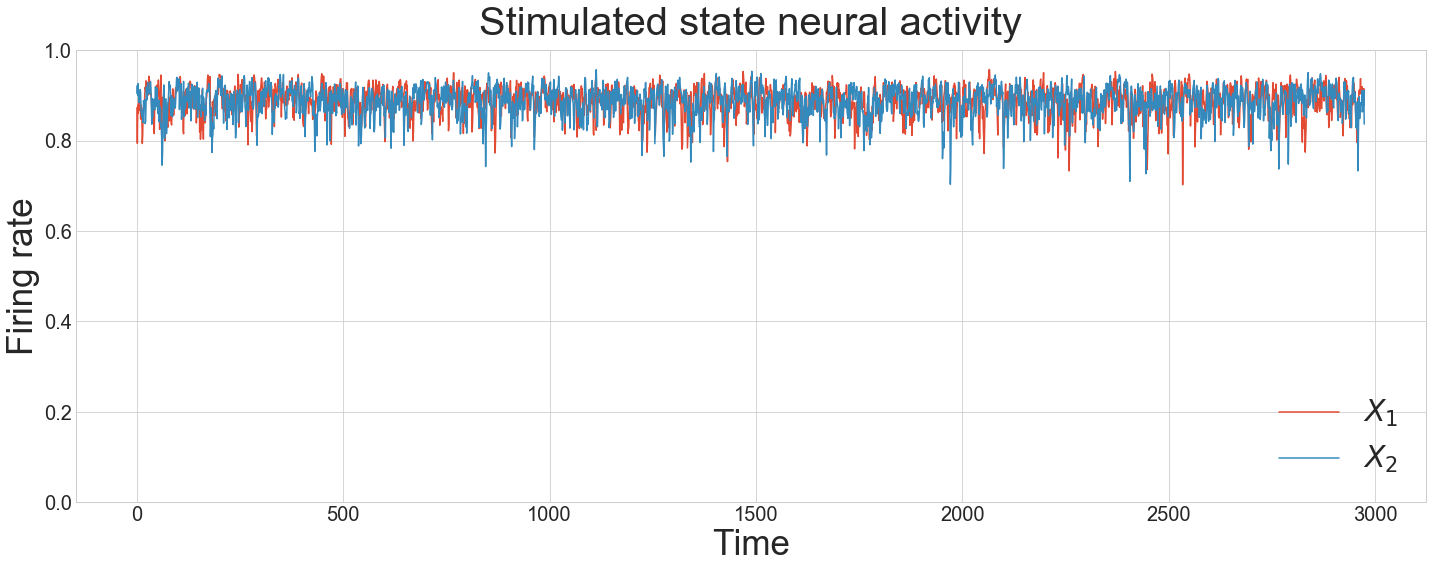

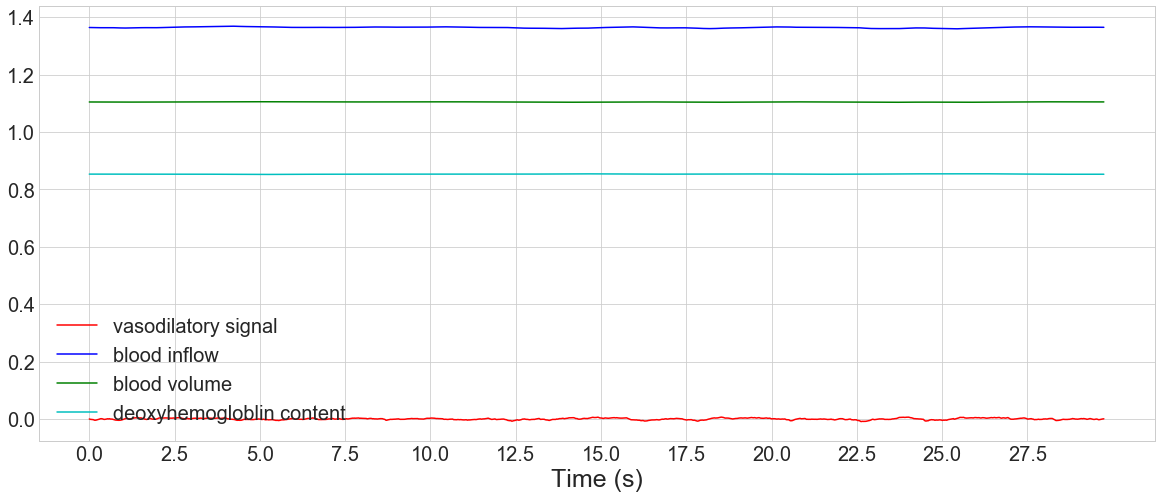

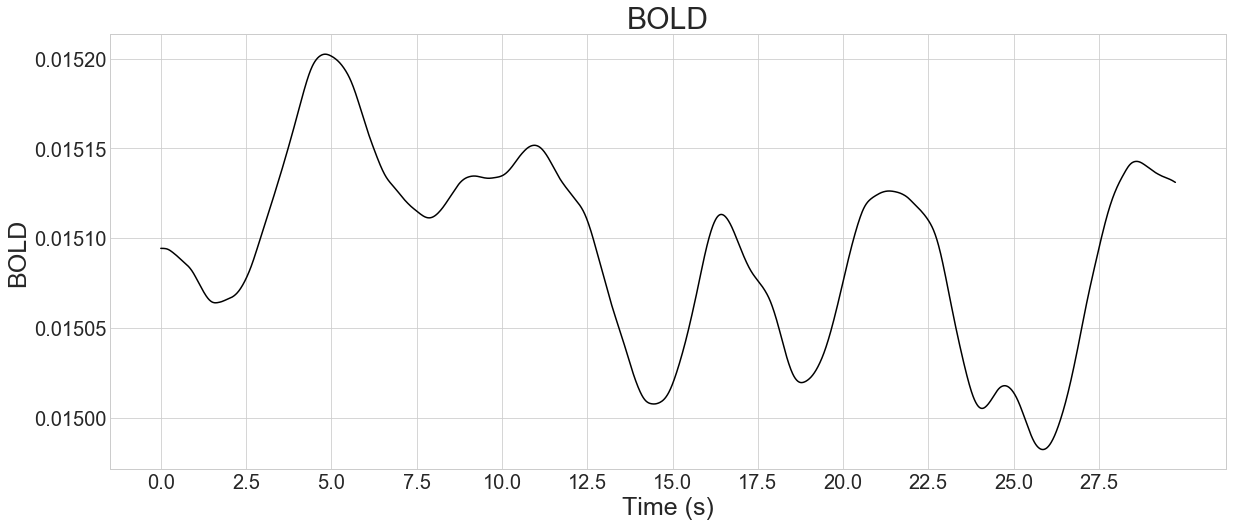

In [129]:
# Set n timepoints
t = 3000

# d1 = np.zeros((t,))
# d2 = np.zeros((t,))
d1 = np.random.normal(0,1.0,(t,))
d2 = np.random.normal(0,1.0,(t,))
s1 = 2
s2 = 2
s1vec = np.ones((t,))*s1
s2vec = np.ones((t,))*s2
# Set stimulation only to region 1
# s1[stimOnset:stimOffset] = 0

## Identify fixed point
xinit1 = 0
xinit2 = 0
I1fp, I2fp = findFP(w11,w12,w22,w21,b1,b2,s1,s2,10000,xinit1,xinit2,tau1,tau2,dt=.1)

# Set initial conditions
xinit1 = I1fp
xinit2 = I2fp

#####
## Run simulations
I1, I2 = runSim(w11,w12,w22,w21,d1,d2,b1,b2,s1vec,s2vec,t,xinit1,xinit2,tau1,tau2)


# Generate plots
plt.figure(figsize=(20,8))
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

# Plot
sns.set_style('whitegrid')
plt.plot(range(len(I1)),I1,label='$X_1$')
plt.plot(range(len(I2)),I2,label='$X_2$')
plt.xlabel('Time',fontsize=35)
plt.ylabel('Firing rate',fontsize=35)
plt.title('Stimulated state neural activity', fontsize=40,y=1.02)
lgd = plt.legend(loc=4,prop={'size': 30})
plt.ylim([0,1.0])
plt.tight_layout()


# Transform BOLD activity
sampling_rate = 0.01 # in seconds
z = np.vstack((I1,I2))

BOLD, s, f, v, q = bw.balloonWindkessel(z, sampling_rate=sampling_rate) 

plt.figure(figsize=(20,8))
plt.plot(s[0,:],'r',label='vasodilatory signal')
plt.plot(f[0,:],'b',label='blood inflow')
plt.plot(v[0,:],'g',label='blood volume')
plt.plot(q[0,:],'c',label='deoxyhemogloblin content')
plt.xticks(np.arange(0,t,250),np.arange(0,t,250)*sampling_rate)
plt.xlabel('Time (s)', fontsize=25)
plt.legend(fontsize=20)

plt.figure(figsize=(20,8))
plt.plot(BOLD[0,:],'k')
plt.title('BOLD',fontsize=30)
plt.xticks(np.arange(0,t,250),np.arange(0,t,250)*sampling_rate)
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('BOLD',fontsize=25)

print 'Range:',np.max(BOLD[0,:]) - np.min(BOLD[0,:])
